In [48]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from scipy.stats import variation
from sklearn import dummy
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import neighbors, metrics
from scipy.stats import variation

from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error, r2_score

seed=42

# Sommaire

## - I/ Import du dataset finalisé    
## - II/ Prédiction de "TotalGHGEmissions"
    # II-1/ Avec la variable "ENERGYSTARScore"
    # II-2/ Sans la variable "ENERGYSTARScore"
## - III/ Constats

# I/ Import du dataset finalisé  

In [49]:
data_model = pd.read_csv("data_finalise.csv", sep=",")
del data_model["Unnamed: 0"]
data_model.head()

,OSEBuildingID,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,Building_Age,Distance,NumberofFloors,NumberofBuildings,PropertyGFATotal,BuildingType_Campus,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
0,1,-0.259891,-0.046699,0.083391,1.065586,-1.217047,1.148926,-0.089713,-0.130754,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,-0.217439,0.005657,0.145566,-1.056387,-1.219976,1.001265,-0.089713,-0.053570,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,-0.981585,2.835632,2.575937,-0.226050,-1.255125,5.431108,-0.089713,4.294963,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,-0.429702,-0.068815,0.132787,1.096339,-1.287345,0.853603,-0.089713,-0.269053,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,0.376898,0.265448,0.428997,-0.564335,-1.202402,2.034895,-0.089713,0.313748,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
data_model.isna().sum()

OSEBuildingID                                      0
ENERGYSTARScore                                    0
SiteEnergyUseWN(kBtu)                              0
TotalGHGEmissions                                  0
Building_Age                                       0
Distance                                           0
NumberofFloors                                     0
NumberofBuildings                                  0
PropertyGFATotal                                   0
BuildingType_Campus                                0
BuildingType_NonResidential                        0
BuildingType_Nonresidential COS                    0
BuildingType_Nonresidential WA                     0
BuildingType_SPS-District K-12                     0
PrimaryPropertyType_Distribution Center            0
PrimaryPropertyType_Hospital                       0
PrimaryPropertyType_Hotel                          0
PrimaryPropertyType_K-12 School                    0
PrimaryPropertyType_Laboratory                

In [52]:
data_model.shape

(1501, 53)

Préparation des jeux de données
Les données numériques ont été normalisées et les données catégorielles ont été converties en données numériques.
Séparons nos données en un jeu d’entraînement et un jeu de test. Le jeu de test contiendra 20% des données. On paramètre 'random_state' avec la valeur du seed pour que la séparation des données soit fixe et reproductible.

# II/ Prédiction de "TotalGHGEmissions"

## II-1/ Avec la variable "ENERGYSTARScore"

In [53]:
X_tghge = data_model.copy()
y_tghge = X_tghge['TotalGHGEmissions']
X_tghge = X_tghge.drop(['SiteEnergyUseWN(kBtu)','TotalGHGEmissions'], axis=1)

X_tghge = X_tghge[X_tghge.columns]

X_train_tghge, X_test_tghge, y_train_tghge, y_test_tghge = model_selection.train_test_split(X_tghge, y_tghge,
                                      test_size=0.2 # 20% des données dans le jeu de test
                                      , random_state=42)

print("La taille du jeu d'entrainement est de {} bâtiments.".format(X_train_tghge.shape[0]))
print("La taille du jeu de test est de {} bâtiments.".format(X_test_tghge.shape[0]))

La taille du jeu d'entrainement est de 1200 bâtiments.
La taille du jeu de test est de 301 bâtiments.


In [54]:
X_test_tghge

,OSEBuildingID,ENERGYSTARScore,Building_Age,Distance,NumberofFloors,NumberofBuildings,PropertyGFATotal,BuildingType_Campus,BuildingType_NonResidential,BuildingType_Nonresidential COS,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
1117,24537,0.207087,-0.533582,1.603643,-0.475350,-0.089713,-0.411871,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
643,20182,0.928781,-0.318309,0.871376,-0.475350,-0.089713,-0.447341,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
422,654,-0.005176,-0.349062,0.285563,-0.475350,-0.089713,-0.293271,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
413,639,-2.127805,0.973326,-0.256314,-0.180027,-0.089713,-0.272766,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451,708,-0.132534,-0.748854,-0.792333,0.410619,-0.089713,0.833536,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,19873,-1.448564,0.942573,-1.014942,-0.327688,-0.089713,-0.447831,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1343,27205,1.141044,0.235249,1.753025,-0.475350,-0.089713,-0.366944,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
654,20377,1.353307,-0.595088,0.361719,-0.180027,-0.089713,-0.182066,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
619,19910,-0.641965,0.296755,-1.164324,-0.032366,-0.089713,-0.445790,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Hyperparamètres avec GridSearchCV des différents modèles
GridSearch est une approche de réglage des paramètres qui permettra d'évaluer méthodiquement un modèle pour chaque paramètres d'algorithme spécifiés dans une grille.

## Algorithme XGBoost

C’est une méthode ensembliste qui fait partie de la famille des algorithmes de boosting qui se base sur les arbres de décision et qui utilise plus particulièrement le boosting de gradient.

Cet algorithme construit un modèle faible qui donne de très mauvais résultats, il tire des conclusions sur les erreurs qui existent entre la prédiction et la réalité. A partir de ces conclusions et des conditions prises lors de la création du premier arbre, il va construire un modèle plus solide en tentant de réduire l'erreur de prédiction du modèle précédent (prédiction des erreurs en donnant un poids élevé aux mauvaises prédictions de l'arbre précédent pour ne plus la refaire). Il s'agit ici d'un système itératif car la formation de l'arbre au temps T à besoin que l'arbre T-1 soit formé pour pouvoir prédire et améliorer les erreurs sur le modèle.

Hyperparamètre :
- n_estimators : nombre d'arbres de décision (nbre d'arbres séquentiels pour corriger les arbres précédents);
- max_depth : nombre maximum de niveaux dans chaque arbre de décision;
- learning_rate : Accroître le taux d'apprentissage (également appelé "eta") et réduit donc la pondération des variables pour éviter l'overfitting;
- gamma : Réduction minimale des pertes requise pour créer une partition supplémentaire sur un nœud feuille de l'arbre. Plus le gamma est grand, plus l'algorithme sera conservateur;
- min_child_weight: Nbre d'échantillon requis pour former un noeud (Profondeur maximale d'un arbre). L'augmentation de cette valeur rendra le modèle plus complexe et plus susceptible de sur-ajuster. 0 indique aucune limite de profondeur;

In [55]:
from datetime import datetime
start_time = datetime.now()

# On fixe les valeurs des hyperparamètres à tester
param_grid = {'n_estimators':  [5, 100, 200], #nombre d'arbres de décision
              'max_depth': [20,50,5],#nombre maximum de niveaux dans chaque arbre de décision
              'learning_rate': [0.02, 0.05, 0.1],
              'gamma': [0.5, 1, 3],
            'min_child_weight': [1, 3, 5],
             }

# Choisir un score à optimiser
score = 'r2'

# define the model/ estimator
model = XGBRegressor(random_state=42, verbosity = 0) #verbosity = 0 : silent : les messages warning ne sont pas 
                                                #affichés.  (0 :"silent", 1:"warning", 2:"info", 3:"debug")

# On utilise GridSearchCV
xgbr= GridSearchCV(model, param_grid, scoring=score, cv=5)   

# On optimise sur le jeu d'entraînement
xgbr.fit(X_train_tghge, y_train_tghge)

#On généralise
y_xgbr_tghge_pred = xgbr.predict(X_test_tghge)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(xgbr.best_params_)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement:")
print(xgbr.best_score_)
print(' ')
#RMSE
print("RMSE: %.3f" % np.sqrt(mean_squared_error(y_test_tghge, y_xgbr_tghge_pred)))
print(' ')
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        xgbr.cv_results_['mean_test_score'], # score moyen
        xgbr.cv_results_['std_test_score'],  # écart-type du score
        xgbr.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )
end_time = datetime.now()
print('Durée d\'exécution : {}'.format(end_time - start_time))

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100}
 
Meilleur(s) score sur le jeu d'entraînement:
0.4222121101727726
 
RMSE: 1.270
 
Résultats de la validation croisée :
r2 = -0.301 (+/-0.754) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 5}
r2 = 0.339 (+/-0.965) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 100}
r2 = 0.239 (+/-1.466) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 200}
r2 = -0.307 (+/-0.764) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 5}
r2 = 0.362 (+/-0.674) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 100}
r2 = 0.366 (+/-0.811) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 3, 

On a un r2 à 0.422 et RMSE à 1.27

In [67]:
#RMSE & r2
df6 = pd.DataFrame(np.array([["",""], [1.27, 0.422]]),
                   index=["XGBoost", "TotalGHGEmissions avec EnergyStarScore"], 
                   columns=["RMSE", "r2"])
print("Score après gridSearchCV")
df6

Score après gridSearchCV


,RMSE,r2
XGBoost,,
TotalGHGEmissions avec EnergyStarScore,1.27,0.422


In [56]:
tab_xgbr_tghge=pd.DataFrame({'Valeur réelle':y_test_tghge, 'Valeur prédite':y_xgbr_tghge_pred})
tab_xgbr_tghge

,Valeur réelle,Valeur prédite
1117,-0.167625,-0.179957
643,-0.211709,-0.201654
422,-0.164183,-0.168729
413,-0.191341,-0.168729
451,-0.135115,0.060606
...,...,...
610,-0.209595,-0.178292
1343,-0.188224,-0.201654
654,-0.224000,-0.069029
619,-0.240696,-0.176024


Text(0, 0.5, 'Valeurs prédictes')

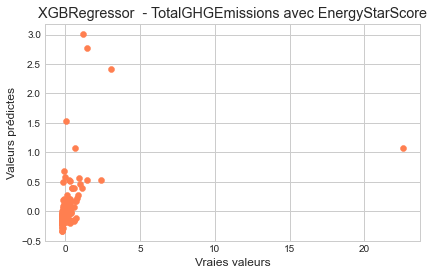

In [57]:
plt.title("XGBRegressor  - TotalGHGEmissions avec EnergyStarScore")
plt.scatter(y_test_tghge, y_xgbr_tghge_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

### Feature Importance
Regardons comment chaque variable a influencé le modèle XGBoost

Text(0.5, 0, 'Xgboost Feature Importance')

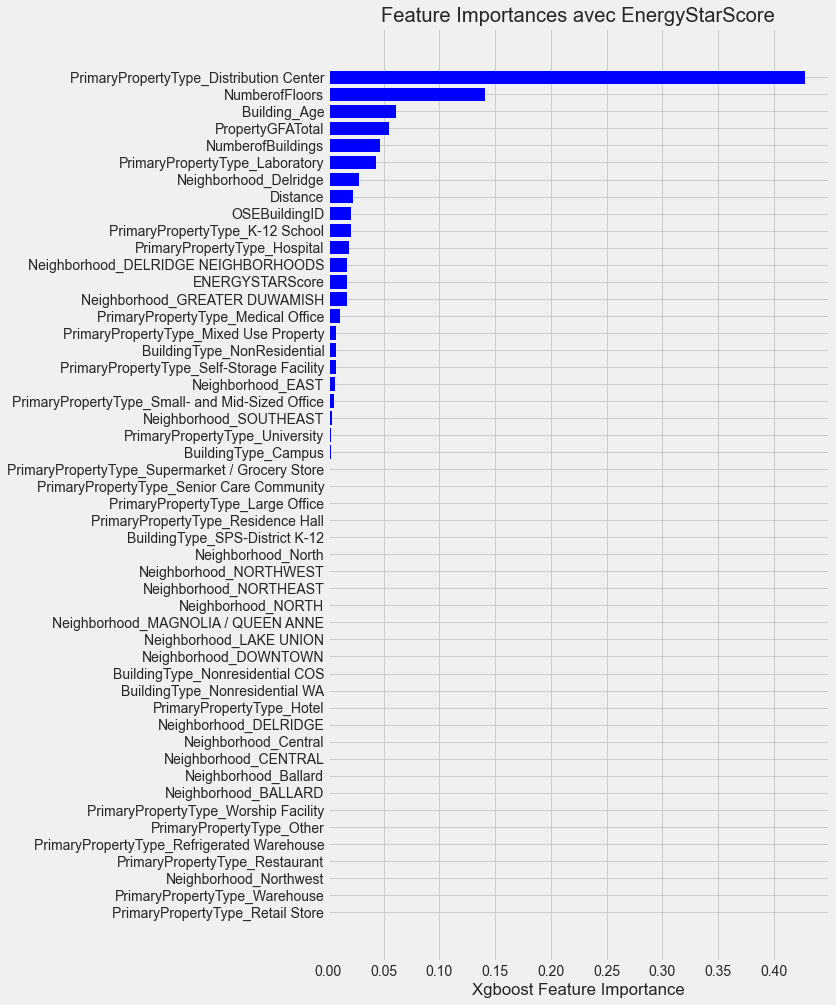

In [70]:
liste_variables=X_test_tghge.columns
importances = xgbr.best_estimator_.feature_importances_
indices = np.argsort(importances)

# style du graphique 
plt.figure(figsize=(8,16))
plt.style.use('fivethirtyeight')
plt.title('Feature Importances avec EnergyStarScore')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel("Xgboost Feature Importance")

### On observe que si on veut avoir un modèle précis, on doit garder les 5 features suivants "PrimaryPropertyType", "NumberofBuilding","Distance" ,"PropertyGFATotal" et "Building_Type".

## II-2/ Sans la variable "ENERGYSTARScore"

In [59]:
X_tghge_e = data_model.copy()
y_tghge_e = X_tghge_e['TotalGHGEmissions']
X_tghge_e = X_tghge_e.drop(['SiteEnergyUseWN(kBtu)','TotalGHGEmissions','ENERGYSTARScore'], axis=1)

X_tghge_e = X_tghge_e[X_tghge_e.columns]

X_train_tghge_e, X_test_tghge_e, y_train_tghge_e, y_test_tghge_e = model_selection.train_test_split(X_tghge_e, 
                                      y_tghge_e, test_size=0.2 # 20% des données dans le jeu de test
                                      , random_state=42)

print("La taille du jeu d'entrainement est de {} bâtiments.".format(X_train_tghge_e.shape[0]))
print("La taille du jeu de test est de {} bâtiments.".format(X_test_tghge_e.shape[0]))

La taille du jeu d'entrainement est de 1200 bâtiments.
La taille du jeu de test est de 301 bâtiments.


In [60]:
X_test_tghge_e

,OSEBuildingID,Building_Age,Distance,NumberofFloors,NumberofBuildings,PropertyGFATotal,BuildingType_Campus,BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,...,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_North,Neighborhood_Northwest,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST
1117,24537,-0.533582,1.603643,-0.475350,-0.089713,-0.411871,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
643,20182,-0.318309,0.871376,-0.475350,-0.089713,-0.447341,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
422,654,-0.349062,0.285563,-0.475350,-0.089713,-0.293271,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
413,639,0.973326,-0.256314,-0.180027,-0.089713,-0.272766,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451,708,-0.748854,-0.792333,0.410619,-0.089713,0.833536,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,19873,0.942573,-1.014942,-0.327688,-0.089713,-0.447831,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1343,27205,0.235249,1.753025,-0.475350,-0.089713,-0.366944,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
654,20377,-0.595088,0.361719,-0.180027,-0.089713,-0.182066,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
619,19910,0.296755,-1.164324,-0.032366,-0.089713,-0.445790,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Algorithme XGBoost

On applique le même algorithme XGBoost avec les même hyperparamètres (avec GridSearchCV) que précédemment.

In [61]:
from datetime import datetime
start_time = datetime.now()
# On fixe les valeurs des hyperparamètres à tester
param_grid = {'n_estimators':  [5, 100, 200], #nombre d'arbres de décision
              'max_depth': [20,50,5],#nombre maximum de niveaux dans chaque arbre de décision
              'learning_rate': [0.02, 0.05, 0.1],
              'gamma': [0.5, 1, 3],
            'min_child_weight': [1, 3, 5],
             }
# Choisir un score à optimiser
score = 'r2'

# define the model/ estimator
model = XGBRegressor(random_state=42, verbosity = 0) #verbosity = 0 : silent : les messages warning ne sont pas 
                                                #affichés.  (0 :"silent", 1:"warning", 2:"info", 3:"debug")

# On utilise GridSearchCV
xgbr= GridSearchCV(model, param_grid, scoring=score, cv=5)   

# On optimise sur le jeu d'entraînement
xgbr.fit(X_train_tghge_e, y_train_tghge_e)

#On généralise
y_xgbr_tghge_e_pred = xgbr.predict(X_test_tghge_e)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(xgbr.best_params_)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement:")
print(xgbr.best_score_)
print(' ')
print("RMSE: %.3f" % np.sqrt(mean_squared_error(y_test_tghge_e, y_xgbr_tghge_e_pred)))
print(' ')
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        xgbr.cv_results_['mean_test_score'], # score moyen
        xgbr.cv_results_['std_test_score'],  # écart-type du score
        xgbr.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )
end_time = datetime.now()
print('Durée d\'exécution : {}'.format(end_time - start_time))

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 50, 'min_child_weight': 5, 'n_estimators': 200}
 
Meilleur(s) score sur le jeu d'entraînement:
0.41767475619899896
 
RMSE: 1.273
 
Résultats de la validation croisée :
r2 = -0.305 (+/-0.753) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 5}
r2 = 0.313 (+/-1.092) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 100}
r2 = 0.212 (+/-1.592) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 1, 'n_estimators': 200}
r2 = -0.308 (+/-0.765) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 5}
r2 = 0.356 (+/-0.733) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 3, 'n_estimators': 100}
r2 = 0.360 (+/-0.869) for {'gamma': 0.5, 'learning_rate': 0.02, 'max_depth': 20, 'min_child_weight': 

On a un r2 à 0.417 et RMSE à 1.27

In [69]:
#RMSE & r2
df7 = pd.DataFrame(np.array([["",""], [1.27, 0.417]]),
                   index=["XGBoost", "TotalGHGEmissions sans EnergyStarScore"], 
                   columns=["RMSE", "r2"])
print("Score après gridSearchCV")
df7

Score après gridSearchCV


,RMSE,r2
XGBoost,,
TotalGHGEmissions sans EnergyStarScore,1.27,0.417


In [62]:
tab_xgbr_tghge=pd.DataFrame({'Valeur réelle':y_test_tghge_e, 'Valeur prédite':y_xgbr_tghge_e_pred})
tab_xgbr_tghge

,Valeur réelle,Valeur prédite
1117,-0.167625,-0.192421
643,-0.211709,-0.202676
422,-0.164183,-0.180672
413,-0.191341,-0.180478
451,-0.135115,-0.127648
...,...,...
610,-0.209595,-0.207573
1343,-0.188224,-0.182014
654,-0.224000,-0.029425
619,-0.240696,-0.202325


Text(0, 0.5, 'Valeurs prédictes')

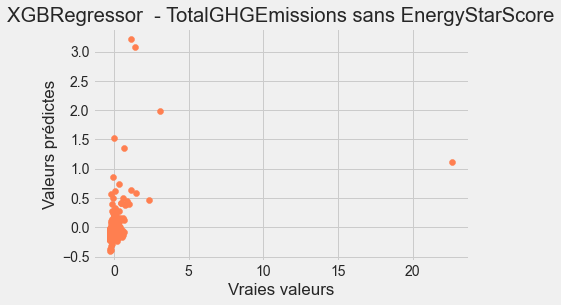

In [63]:
plt.title("XGBRegressor  - TotalGHGEmissions sans EnergyStarScore")
plt.scatter(y_test_tghge_e, y_xgbr_tghge_e_pred, color='coral')
plt.xlabel("Vraies valeurs")
plt.ylabel("Valeurs prédictes")

### Feature Importance
Regardons comment chaque variable a influencé le modèle XGBoost

Text(0.5, 0, 'Xgboost Feature Importance')

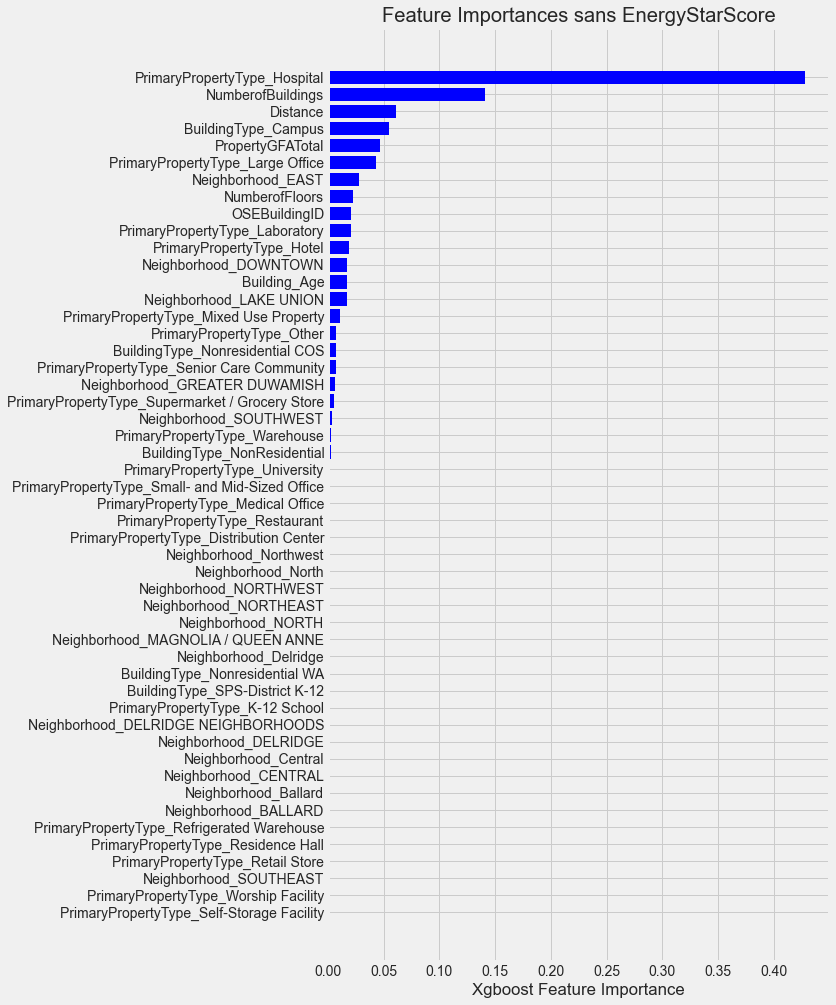

In [71]:
liste_variables=X_test_tghge_e.columns
importances = xgbr.best_estimator_.feature_importances_
indices = np.argsort(importances)

# style du graphique 
plt.figure(figsize=(8,16))
plt.style.use('fivethirtyeight')
plt.title('Feature Importances sans EnergyStarScore')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel("Xgboost Feature Importance")

### On observe que si on veut avoir un modèle précis, on doit garder les 5 features suivants "PrimaryPropertyType", "NumberofBuilding","Distance" ,"Building_Type" et "PropertyGFATotal".

### III/ Constats

On constate que la variable "ENERGYSTARScore" influe sur le score de la prédication. On passe de 0,422 (avec la variable ENERGYSTARScore)  à 0,417 (Sans la variable ENERGYSTARScore)

Cela veut donc dire que lorsque la variable "ENERGYSTARScore" n'est pas présente l'algorithme fait des prédictions moins corrélées et moins proches de la réalité.